In [105]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

In [100]:
def gen_data(N_samples = [30,30,30], 
             G_samples = [18,18,18]):

    group_idx = np.repeat([0,1,2], N_samples)

    data = []
    for g in range(len(N_samples)):
        data.extend(np.repeat([1,0],[G_samples[g], N_samples[g] - G_samples[g]]))

    data = np.array(data)
    return data, group_idx

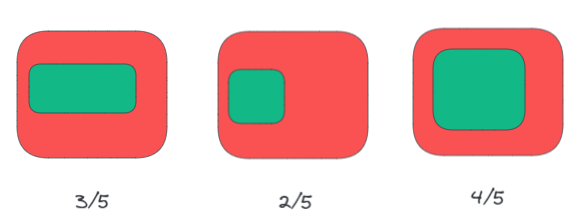

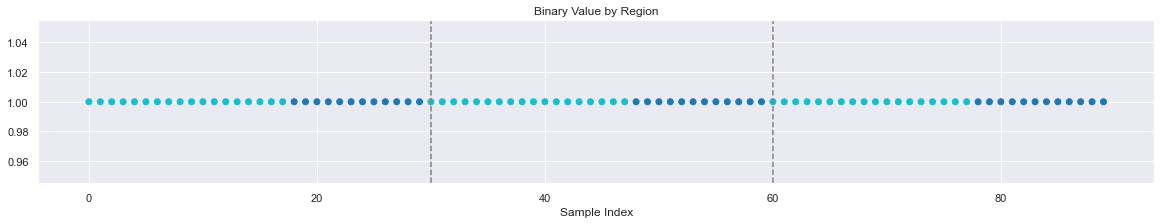

In [101]:
data, group_idx = gen_data()

fig,ax = plt.subplots(figsize = (20,3))
plt.scatter(np.arange(len(data)),
            np.ones(len(data)),
            c = data.astype(int), 
            cmap = 'tab10')
for l in np.cumsum(N_samples)[:-1]:
    plt.axvline(l, linestyle = '--', color = 'gray')

plt.title('Binary Value by Region')
plt.xlabel('Sample Index')
plt.ylabel('')
plt.show()

**Half Cauchy is more likely to get larger values**

In [39]:
from scipy import stats

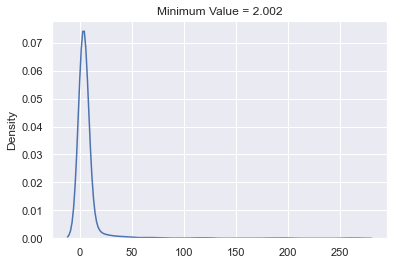

In [56]:
halfCauchyValues = stats.halfcauchy(loc = 2, scale = 1).rvs(1000)

sns.kdeplot(halfCauchyValues)
plt.title("Minimum Value = " + str(halfCauchyValues.min().round(3)), fontsize = 12)
plt.show()

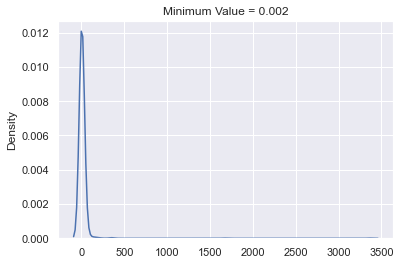

In [71]:
with pm.Model() as model:
    halfcau = pm.HalfCauchy("half",3)
    
sns.kdeplot(halfcau.random(size = 1000))
plt.title("Minimum Value = " + str(halfcau.random(size = 1000).min().round(3)), fontsize = 12)
plt.show()

**Half Normal only gets normal like values, not extremly large values**

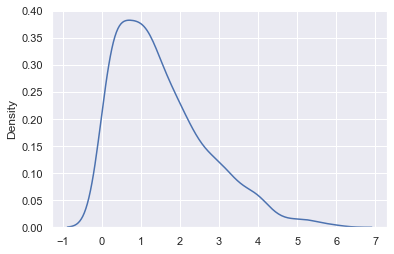

In [95]:
haln = stats.halfnorm(loc = 0, scale = 2).rvs(1000)
sns.kdeplot(haln)
plt.show()

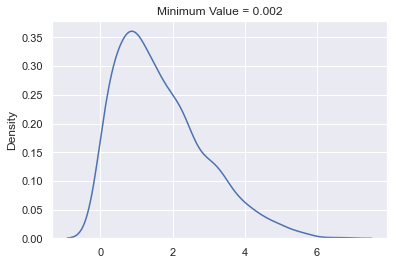

In [96]:
with pm.Model() as model:
    halfn = pm.HalfNormal("half",2)
    
sns.kdeplot(halfn.random(size = 1000))
plt.title("Minimum Value = " + str(halfn.random(size = 1000).min().round(3)), fontsize = 12)
plt.show()

In [103]:
data, group_idx = gen_data()

In [111]:
with pm.Model() as model:
    alpha = pm.HalfCauchy('alpha',1)
    beta = pm.HalfCauchy('beta',1)
    theta = pm.Beta('theta', alpha, beta, shape = len(N_samples))
    y = pm.Bernoulli('y',theta[group_idx], observed = data)
    step = pm.Metropolis()
    trace = pm.sample(2000,return_inferencedata = True, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [112]:
sub_trace = trace.sel(draw = slice(300, None))

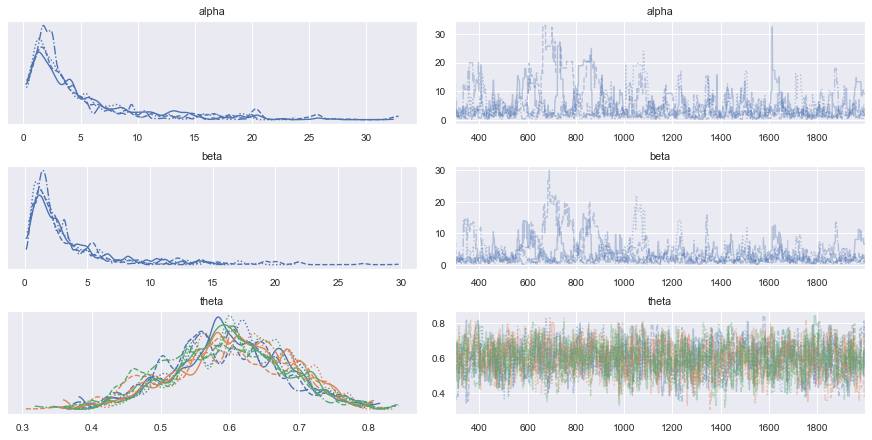

In [113]:
az.plot_trace(sub_trace)
plt.show()

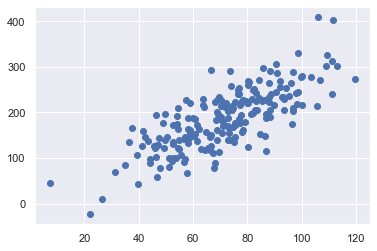

In [150]:
np.random.seed(234)
alpha_real = 2.5
beta_real = 10.3
sigma = 3
x = np.linspace(1,200)
x = np.random.normal(70,20, size = 200)
noise = stats.norm(scale = 40).rvs(len(x))
y = alpha_real*x + beta_real + noise
plt.scatter(x,y)

In [175]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',1, 10)
    beta = pm.Normal('beta',0,10)
    mu = pm.Normal('mu',alpha *x + beta, sigma = 10, shape=  len(x))
    epsilon = pm.HalfCauchy('eps', 50)
    obs = pm.Normal('obs', mu, epsilon, observed = y)
    trace = pm.sample(10000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C21714C70>,
      dtype=object)

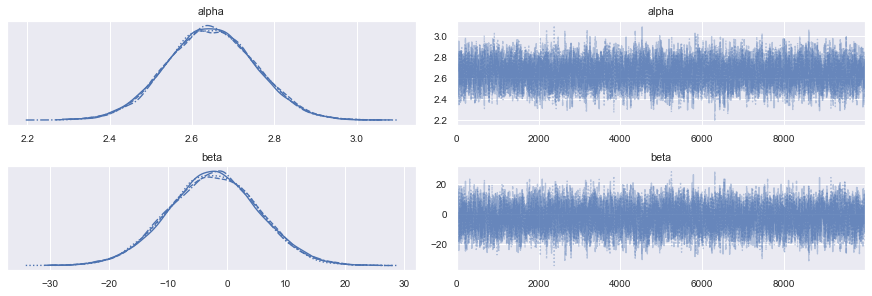

In [179]:
az.plot_trace(trace, var_names=['alpha','beta'])

In [188]:
summary = az.summary(trace.sel(draw = slice(300, None)), var_names=['alpha','beta'])
al = summary['mean']['alpha']
bt = summary['mean']['beta']

In [189]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.646,0.108,2.449,2.851,0.002,0.001,4412.0,8962.0,1.0
beta,-2.322,7.655,-16.675,12.006,0.111,0.078,4761.0,10753.0,1.0


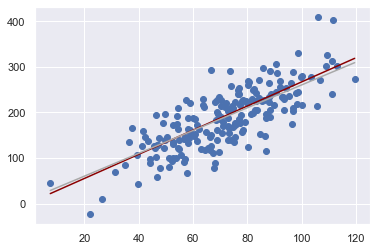

In [190]:
plt.scatter(x,y)
plt.plot([x.min(), x.max()],[al * x.min() -bt, al * x.max() -bt], color = 'darkred')
plt.plot([x.min(), x.max()],[2.5 * x.min() + 10.3, 2.5 * x.max() + 10.3], color = 'darkgray')
plt.show()


### Convert Slope and Intercept from Normalized Regression
$x^{'} = \frac{x - \bar{x}}{\sigma_{x}}$$,$$y^{'} = \frac{y - \bar{y}}{\sigma_{y}}$   
$y^{'} = \alpha^{'} + \beta^{'} x^{'}$   
$\frac{y - \bar{y}}{\sigma_{y}} = \alpha^{'} + \beta^{'}\frac{x - \bar{x}}{\sigma_{x}}$   
$y= \alpha^{'}{\sigma_{y}} + \bar{y} + \beta^{'}{\sigma_{y}}\frac{x - \bar{x}}{\sigma_{x}}$  
$y= \alpha^{'}{\sigma_{y}} + \bar{y} - \beta^{'}{\sigma_{y}}\frac{\bar{x}}{\sigma_{x}} + \beta^{'}{\sigma_{y}}\frac{x}{\sigma_{x}}$    
$y= [\alpha^{'}{\sigma_{y}} + \bar{y} - \beta^{'}{\sigma_{y}}\frac{\bar{x}}{\sigma_{x}}] + [\beta^{'}\frac{\sigma_{y}}{\sigma_{x}}]x$ 

In [192]:
x_new = (x - x.mean()) / x.std()
y_new = (y - y.mean()) / y.std()

In [197]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',1, 10)
    beta = pm.Normal('beta',0,10)
    mu = pm.Normal('mu',alpha *x_new + beta, sigma = 10, shape=  len(x))
    epsilon = pm.HalfCauchy('eps', 1)
    obs = pm.Normal('obs', mu, epsilon, observed = y_new)
    trace = pm.sample(10000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
There were 1114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5641846922595598, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7269 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2697084817343969, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.711416708210654, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C23289310>,
      dtype=object)

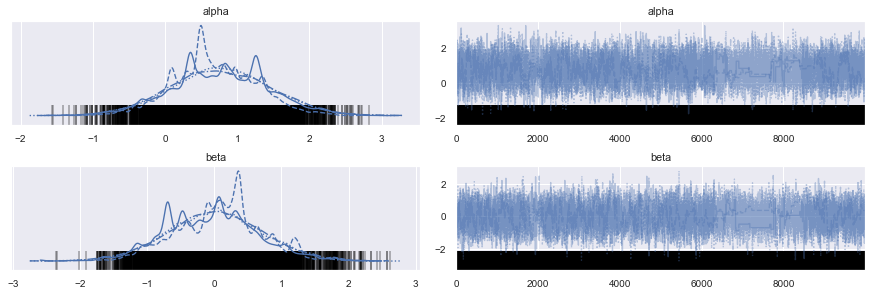

In [198]:
az.plot_trace(trace, var_names=['alpha','beta'])

In [199]:
summary = az.summary(trace.sel(draw = slice(1000, None)), var_names=['alpha','beta'])
al = summary['mean']['alpha']
bt = summary['mean']['beta']

In [205]:
slope = al * y.std() / x.std()
intercept = bt * y.std() + y.mean() - al * y.std() * x.mean() / x.std()

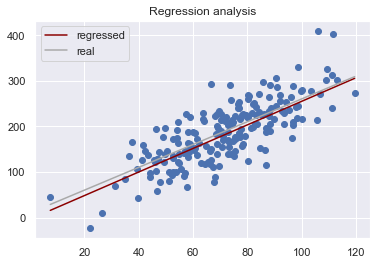

In [208]:
plt.scatter(x,y)
plt.plot([x.min(), x.max()],[slope * x.min() -intercept, slope * x.max() -intercept], color = 'darkred', label = 'regressed')
plt.plot([x.min(), x.max()],[2.5 * x.min() + 10.3, 2.5 * x.max() + 10.3], color = 'darkgray', label = 'real')
plt.legend(loc = 'upper left')
plt.title("Regression analysis")
plt.show()

In [209]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.745,0.657,-0.495,1.989,0.018,0.015,1314.0,3381.0,1.01
beta,0.019,0.692,-1.292,1.286,0.026,0.019,686.0,1238.0,1.01


In [210]:
intercept

3.280181174268165

### Teacher's Code

Text(0.5, 0, '$y$')

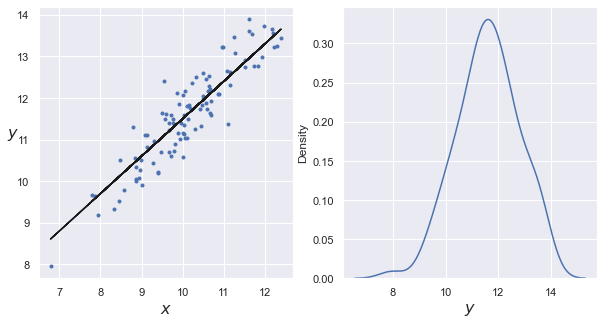

In [211]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

In [218]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = 0, sigma = 10)
    beta = pm.Normal('beta',mu = 0, sigma = 10)
    mu = pm.Deterministic('mu',alpha + beta * x)
    epsilon = pm.HalfCauchy('epsilon',10)
    obs = pm.Normal("obs", mu, epsilon, observed = y)
    trace = pm.sample(10000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
The acceptance probability does not match the target. It is 0.8873320576529404, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


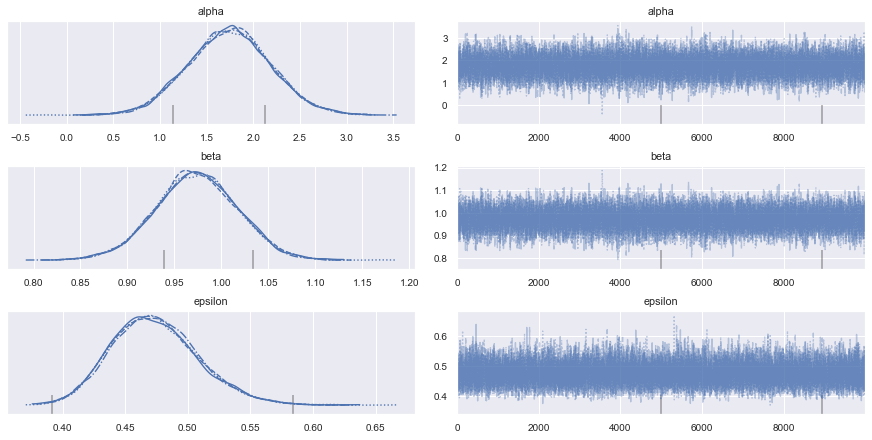

In [221]:
az.plot_trace(trace, var_names = ['alpha','beta','epsilon'])
plt.show()

In [222]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.743,0.444,0.900,2.567,0.004,0.003,11635.0,13931.0,1.0
beta,0.974,0.044,0.892,1.055,0.000,0.000,11677.0,13911.0,1.0
mu[0],11.660,0.047,11.571,11.748,0.000,0.000,36247.0,31096.0,1.0
mu[1],9.985,0.087,9.825,10.150,0.001,0.001,13715.0,18316.0,1.0
mu[2],11.396,0.048,11.305,11.486,0.000,0.000,32203.0,30982.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[96],13.124,0.083,12.970,13.280,0.001,0.000,15985.0,20565.0,1.0
mu[97],9.410,0.109,9.213,9.623,0.001,0.001,12733.0,16939.0,1.0
mu[98],12.157,0.053,12.056,12.256,0.000,0.000,26970.0,28526.0,1.0
mu[99],11.589,0.047,11.500,11.677,0.000,0.000,35843.0,31126.0,1.0


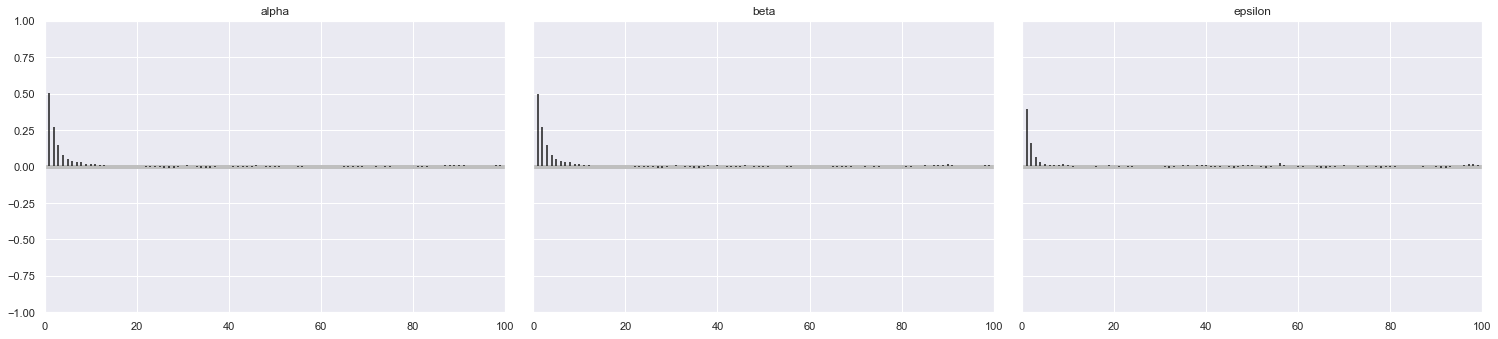

In [225]:
az.plot_autocorr(trace, var_names = ['alpha','beta','epsilon'], combined = True)
plt.show()

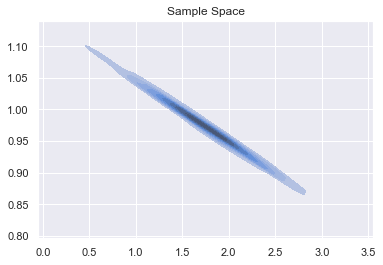

In [233]:
sns.kdeplot(x = trace.posterior['alpha'].values.reshape(-1)[-1000:],
            y = trace.posterior['beta'].values.reshape(-1)[-1000:],
           shade = True)
plt.title('Sample Space')
plt.show()

In [234]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = 0, sigma = 10)
    beta = pm.Normal('beta',mu = 0, sigma = 10)
    mu = pm.Deterministic('mu',alpha + beta * (x - x.mean()))
    epsilon = pm.HalfCauchy('epsilon',10)
    obs = pm.Normal("obs", mu, epsilon, observed = y)
    trace = pm.sample(10000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.


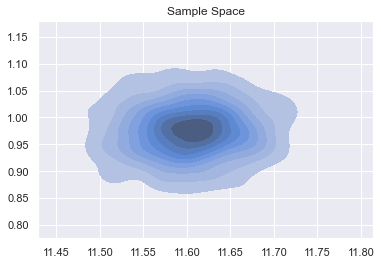

In [235]:
sns.kdeplot(x = trace.posterior['alpha'].values.reshape(-1)[-1000:],
            y = trace.posterior['beta'].values.reshape(-1)[-1000:],
           shade = True)
plt.title('Sample Space')
plt.show()

In [236]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,11.604,0.048,11.514,11.695,0.000,0.0,46662.0,28928.0,1.0
beta,0.974,0.044,0.891,1.056,0.000,0.0,49192.0,29562.0,1.0
mu[0],11.660,0.048,11.570,11.751,0.000,0.0,46678.0,28797.0,1.0
mu[1],9.985,0.088,9.823,10.152,0.000,0.0,48464.0,29625.0,1.0
mu[2],11.396,0.049,11.303,11.488,0.000,0.0,46936.0,28286.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[96],13.125,0.084,12.965,13.281,0.000,0.0,48589.0,29265.0,1.0
mu[97],9.410,0.110,9.209,9.621,0.001,0.0,48781.0,29872.0,1.0
mu[98],12.157,0.054,12.054,12.258,0.000,0.0,47126.0,29381.0,1.0
mu[99],11.589,0.048,11.499,11.680,0.000,0.0,46662.0,29105.0,1.0


In [243]:
s = az.summary(trace)['mean']
alpha = s['alpha'] - s['beta']*x.mean()
beta = s['beta']

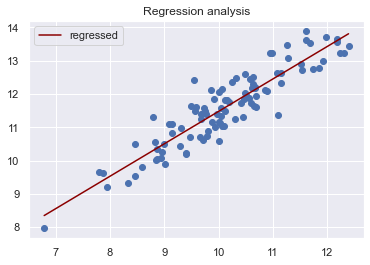

In [246]:
plt.scatter(x,y)
plt.plot([x.min(), x.max()],[beta * x.min() + alpha, beta * x.max() +alpha], color = 'darkred', label = 'regressed')
plt.legend(loc = 'upper left')
plt.title("Regression analysis")
plt.show()